In [8]:
import sys
# Define relative path.
sys.path.append("python")

In [9]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sampling_trajectory import morris_trajectory
from screening_measures_gm_2017 import screening_measures_gm_2017

In [36]:
"""Perhaps I need to add the scaled Elementary Effects (by SD)"""

'Perhaps I need to add the scaled Elementary Effects (by SD)'

In [10]:
def bar_plot(input_par_array):
    new_list = input_par_array.reshape(-1, 1).tolist()
    merged = pd.Series(itertools.chain.from_iterable(new_list))
    vc = merged.value_counts().sort_index()
    vc /= float(vc.sum())
    assert vc.sum() > 0.999
    ax = vc.plot(kind='bar')
    fig = ax.get_figure()
    fig.autofmt_xdate()

In [11]:
seed = 2020
n_levels = 10
n_inputs = 3
n_traj_sample = 10_000

sample_traj_list = list()

for traj in range(0, n_traj_sample):
    seed = seed + traj
    sample_traj_list.append(morris_trajectory(n_inputs, n_levels, seed=seed))

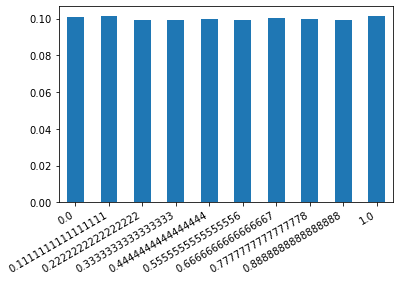

In [12]:
bar_plot(np.vstack(sample_traj_list))

In [13]:
expectation = np.array([0, 0, 0])
cov = np.array(
    [
        [1.0, +0.5, 0.0],
        [+0.5, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)

In [14]:
def linear_function(a, b, c, *args):
    return a + b + c

In [15]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linear_function, sample_traj_list, cov, n_levels, mu=expectation)

In [16]:
abs_ee_ind

array([[3.04101661],
       [3.05235663],
       [3.5142955 ]])

In [17]:
abs_ee_full

array([[5.26719528],
       [5.28683677],
       [3.5142955 ]])

In [18]:
sd_ee_ind

array([[3.11091538],
       [3.12209522],
       [3.59528995]])

In [19]:
sd_ee_full

array([[5.3882635 ],
       [5.40762754],
       [3.59528995]])

In [20]:
"""Ishigami"""
def ishigami(q0, q1, q2, a=2, b=3):
    """Note: Originally, this function takes uniform, not standard normally distributed inputs"""
    return np.sin(q0) + a*(np.sin(q1))**2 + b*q2**4*np.sin(q0)

In [21]:
a=2
b=3
vals = [0.5 + (a**2)/8 + (b*(np.pi**4))/5 + ((b**2)*(np.pi**8)/18),
        (0.5 + b*(np.pi**4)/5 + (b**2)*(np.pi**8)/50), (a**2)/8,
         0, 0, (8*b**2*np.pi**8)/225, 0, 0]
total_order = [(vals[1]+vals[5])/vals[0], vals[2]/vals[0], vals[5]/vals[0]]

In [22]:
total_order # Compare with SDs not with EEs.

[0.9998959138041636, 0.00010408619583630811, 0.6320800624240672]

In [23]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(ishigami, sample_traj_list, cov, n_levels, mu=expectation)

In [24]:
abs_ee_ind

array([[37.13096783],
       [ 2.11609088],
       [40.12729498]])

In [25]:
abs_ee_full

array([[43.25851073],
       [24.08866555],
       [40.12729498]])

In [26]:
sd_ee_ind

array([[78.77364513],
       [ 2.36344933],
       [65.37641073]])

In [27]:
sd_ee_full

array([[86.74814038],
       [51.58131713],
       [65.37641073]])

In [28]:
"""
new experiment, see on page 15 in
http://www2.stat.duke.edu/~fei/samsi/Readings/06LinkBingHengHigfYe.pdf

"""
seed = 2020
n_levels = 10
n_inputs = 8
n_traj_sample = 10_000

sample_traj_list = list()

for traj in range(0, n_traj_sample):
    seed = seed + traj
    sample_traj_list.append(morris_trajectory(n_inputs, n_levels, seed=seed))

In [29]:
def linkletter_et_al_2006(x0, x1, x2, x3, x4, x5, x6, x7, *args):
    epsilon = np.random.normal(0, 0.05)
    return 0.2*x0 + (0.2/2)*x1 + (0.2/4)*x2 + (0.2/8)*x3 + (0.2/16)*x4 + (0.2/32)*x5 + (0.2/64)*x6 + (0.2/128)*x7 + epsilon

In [30]:
expectation = np.array([0, 0, 0, 0, 0, 0, 0, 0])


cov = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    ]
)

In [31]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linkletter_et_al_2006, sample_traj_list, cov, n_levels, mu=expectation)

In [32]:
abs_ee_ind

array([[0.70194624],
       [0.35217938],
       [0.18848161],
       [0.12576503],
       [0.10816584],
       [0.10269197],
       [0.10085846],
       [0.10087957]])

In [33]:
abs_ee_full

array([[0.70005253],
       [0.3511992 ],
       [0.18675411],
       [0.12670118],
       [0.10802834],
       [0.10303452],
       [0.10259954],
       [0.10083775]])

In [34]:
sd_ee_ind

array([[0.72925661],
       [0.38167871],
       [0.22180608],
       [0.15566111],
       [0.13517422],
       [0.12883488],
       [0.12641959],
       [0.12644807]])

In [35]:
sd_ee_full

array([[0.7273522 ],
       [0.37999654],
       [0.22066547],
       [0.15702379],
       [0.13574865],
       [0.12880063],
       [0.12811924],
       [0.12641977]])